# Multilayer perceptron
In this notebook we will implement a multilayer perceptron (MLP) with only one single hidden layer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

numpy version: 1.23.1
pandas version: 1.4.3


## The MNIST data set
The MNIST data set is a collection of 70000 28x28 pixels images representing the digits from 0 to 9. the data set is composed of a matrix of 70000 rows, one for each image, and 784 columns that represent the pixel values. The labels are represented in an array of 70000 rows and each value represents the class of that image, that is the digit of the corresponding image.  

In [9]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [10]:
X_std = ((X / X.max()) - .5) * 2
X_std.min(), X_std.max()

(-1.0, 1.0)

We plot a sample of the 10 digits

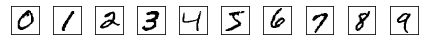

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_std[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

And ten examples of handwritten digit 7

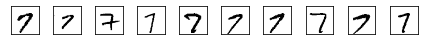

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=10, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_std[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### Data partition
We split the data set into two subsets, a training set, a validation set, and a test set.

In [13]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(X_std, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp

print(X_train.shape), print(X_valid.shape), print(X_test.shape)

(55000, 784)
(5000, 784)
(10000, 784)


(None, None, None)

## The multilayer perceptron model
We define a MLP class that implements three functions: an init() function to initialize the matrix that will contain the weights of the hidden layer, a forward() function to compute the digit class from an input image, and a backward() function to compute the derivatives of the cost function that are used to update the weights with the backpropagation algorithm. 

We implement the activation function (sigmoid) and a function of the one-hot encoding of the labels.

In [14]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

The functions init(), forward() and backward() definitions are similar to the functions defined in PyTorch for a neural network. The size of the weight matrix that represent the connection between the units of the input layer and the units of the hidden layer is (number of features)x(number of units in the hidden layer), in our case 784x50. The size of the 2nd matrix that connects the output of the hidden layer and the output layer is (number of units in the hidden layer)x(number of classes), in our case 50x10. The weights are initialized by sampling from a normal distribution.

In [15]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

## The training loop
Once we have defined our model and implemented the functions to define the structure of the network, the forward function and the backpropagation algorithm to update the weights in order to minimize the loss, we can instantiate our neural network model and start the training process.

In [16]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

### The data loading
We define a function that creates the mini batches that will be used as input to the network during the training process. Each batch will be used to update the weights as in the stochastic gradient descent (SGD) algorithm used for the backward propagation. The difference between gradient descent and SGD is that with gradient descent the weight are updated using all the training at every epoch while with SGD the weights are updated using a small subset, called the minibatch. 

In [18]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

We split the training data set into minibatches of 100 images

In [19]:
num_epochs = 50
minibatch_size = 100

# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


### The performance metric
We define the performance metric to monitor the training process and update the weights accordingly. The loss fumction is the mean squared error (MSE loss)

In [20]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

We compute the predictions, the loss and the accuracy of the model, before the training, for the validation set. The model returns the probability for each of the 10 digits of each sample in the validation set. 

In [24]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
probas.shape

(5000, 10)

For each prediction we extract the index of the digit with highest probability then we compare the predicted digit with the known one to see whether it is correct or not. Since the model was not trained we expect something close to 10% accuracy as there is only 1 chance out of 10 to make the right guess. 

In [28]:
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(predicted_labels.shape)

(5000,)


In [25]:
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


Now we define a function to perform the same computation on the minibatches

In [30]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

We test the function on the same validation set to see whether its results is the same as the one computed using the full validation set 

In [31]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


### The training process
The training process consists of a number of epochs. For each the full training set is used to update the weights of the model. For each epoch the weight are updated after each minibatch has been used to predict the probabilities of the input images that will be compared with the known classes to compute the loss and its gradient with respect to the weights. The gradient of the loss function is used in the backpropagation algorithm to update the weights before the next minibatch is sent through the network for another training cycle. After all the minibatches have been used the epoch is completed and the MSE training and validation loss and accuracy of the network for that epoch are computed and stored into a list to track the training process. 

In [32]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

Now we can start the training process using the function defined above with 50 epochs using the default value for the minibatch size (100)

In [33]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

## Performance evaluation
We can plot the loss of the model at each epoch using the data returned by the train() function.

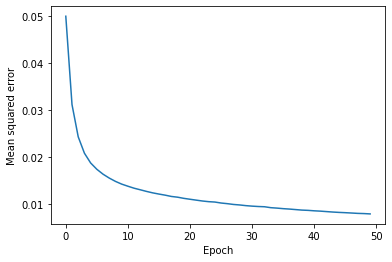

In [34]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

We can compare the progress of the model's accuracy using the training set and the validation set at each epoch of the training procedure. The validation accuracy is only slightly lower than the training accuracy meaning that the model does not overfit the data. Some of the missclassifications are due to underrepresented handwritten images, for example the digit 7 written with a middle horizontal line. 

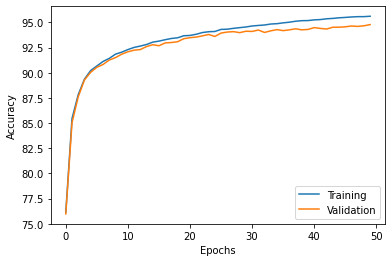

In [35]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

Finally, we can see the model's accuracy for the test set. While the validation set has been used in every epoch, the test set was never used so far. As we can see, the test accuracy is only slightly lower than the validation accuracy. A good result for a small NN model of only two layers.

In [36]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%
